### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree, ensemble, model_selection, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

### Import Datasets

In [2]:
# features
x_train = pd.read_csv('training_set.csv')
x_test = pd.read_csv('testing_set.csv')

# labels
y_train = pd.read_csv('training_labels.csv')
y_test = pd.read_csv('testing_labels.csv')

print(x_train.columns)
print(x_test.columns)
print(y_train.columns)
print(y_test.columns)

Index(['district', 'street', 'propertyType', 'remaining_lease', 'school',
       'hawkercentre', 'supermarkets', 'Bus Stops Nearby', 'crime_number',
       'latitude', 'longitude', 'floor_area_sqm', 'floor_range', 'sentiment'],
      dtype='object')
Index(['district', 'street', 'propertyType', 'remaining_lease', 'school',
       'hawkercentre', 'supermarkets', 'Bus Stops Nearby', 'crime_number',
       'latitude', 'longitude', 'floor_area_sqm', 'floor_range', 'sentiment'],
      dtype='object')
Index(['price'], dtype='object')
Index(['price'], dtype='object')


In [3]:
x_train['sentiment'].isnull().values.any()

False

In [4]:
x_train.head(2)

,district,street,propertyType,remaining_lease,school,hawkercentre,supermarkets,Bus Stops Nearby,crime_number,latitude,longitude,floor_area_sqm,floor_range,sentiment
0,20,1487,8,-0.028291,37,11,5,1,122.714286,1.384051,103.900061,0.333809,1,0.056981
1,21,668,6,0.130119,40,1,8,0,-1.000000,1.358962,103.763673,-0.261162,2,0.145982


### Summary of Results
*Goal: Low RMSE, Low MAE, R2 close to 1, High Adjusted R2*
    
Conclusions:
1. Random Forest better performance
2. For random forest, using Grid Search helped us in finding better estimators to improve the model slightly
3. For decision tree, using Grid Search did not help us to find better estimators (dk why? and the adjusted r2 for the model w grid search is negaative? huh? confused)

### Define function for MAPE

In [5]:
# def mean_absolute_percentage_error(y_true,y_pred):
#     mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
#     return mape

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

### Decision Tree

#### (a) Basic Decision Tree with Default Parameters

[ 0.03943235 -0.41731308 -0.28243523 ... -0.41731308 -0.39095059
 -0.3222855 ]
training mse: 0.00021042789208621134, testing mse: 0.0873536169447071
training rmse: 0.014506132912882445, testing rmse: 0.2955564530588143
training mae: 0.002270979414850658, testing mae: 0.04811321211845092
training R2: 0.9997895703447239, testing R2: 0.9027971617625435
training adjusted R2: 0.9997895456569632, testing adjusted R2: 0.9026944258622472
training mape: 1.3379236270310424, testing mape: 27.352243640918537


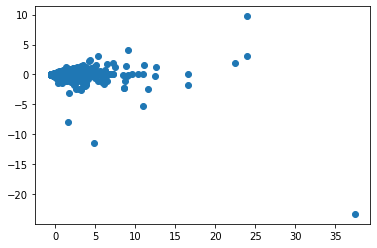

In [27]:
# train model
dt = tree.DecisionTreeRegressor()
dt.fit(x_train,y_train)

# make predictions on test set
y_pred_train = dt.predict(x_train)
y_pred = dt.predict(x_test)
print(y_pred)

# compute metrics 
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred)

train_mae = mean_absolute_error(y_train,y_pred_train)
test_mae = mean_absolute_error(y_test,y_pred)

train_r_squared = r2_score(y_train,y_pred_train)
test_r_squared = r2_score(y_test,y_pred)

train_adj_r_squared = 1 - (1-dt.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
test_adj_r_squared = 1 - (1-dt.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

train_mape = mean_absolute_percentage_error(y_train,y_pred_train)
test_mape = mean_absolute_percentage_error(y_test,y_pred)

print("training mse: {}, testing mse: {}".format(train_mse, test_mse))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(train_mse), np.sqrt(test_mse)))
print("training mae: {}, testing mae: {}".format(train_mae, test_mae))
print("training R2: {}, testing R2: {}".format(train_r_squared, test_r_squared))
# print("training R2: {}, testing R2: {}".format(dt.score(x_train, y_train), dt.score(x_test, y_test)))
print("training adjusted R2: {}, testing adjusted R2: {}".format(train_adj_r_squared, test_adj_r_squared))
print("training mape: {}, testing mape: {}".format(train_mape, test_mape))

# residual plot
x_axis = y_test.squeeze() # fitted value
y_axis = y_test.squeeze()- y_pred.squeeze() # residual
plt.scatter(x_axis,y_axis) 

In [28]:
dt.get_params(deep=True)

{'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

#### (b) Decision Tree using Best Estimators from Grid Search
- did 2 tests to kinda see which one better

In [7]:
# test 1: best parameter is 'max_leaf_nodes': [200,400,600,800], 'min_samples_split': [7,12,15,20]

In [8]:
params = {'max_leaf_nodes': [200,400,600,800], 'min_samples_split': [7,12,15,20]}
gsearch_dt = GridSearchCV(tree.DecisionTreeRegressor(random_state=42), 
                          params, 
                          scoring = 'neg_mean_squared_error',
                          verbose=1, 
                          cv=3, 
                          n_jobs=-1)
gsearch_dt.fit(x_train, y_train)
print('best score:', gsearch_dt.best_score_)
print('best parameters: ', gsearch_dt.best_params_)
print('best estimators: ', gsearch_dt.best_estimator_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    8.5s finished


best score: -0.12483695561164763
best parameters:  {'max_leaf_nodes': 800, 'min_samples_split': 15}
best estimators:  DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=800, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=15, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')


[ 0.08558463 -0.39172244 -0.30130996 ... -0.41335421 -0.32597447
 -0.2747952 ]
training mse: 0.03533715262426555, testing mse: 0.10065165780937843
training rmse: 0.18798178801220494, testing rmse: 0.317256454322648
training mae: 0.058820399567829966, testing mae: 0.06981117871536002
training R2: 0.9646625512832923, testing R2: 0.8879997514176241
training adjusted R2: -0.03545861913453319, testing adjusted R2: -0.10181496169049953
training mape: 50.05130292151184, testing mape: 50.45118955127798


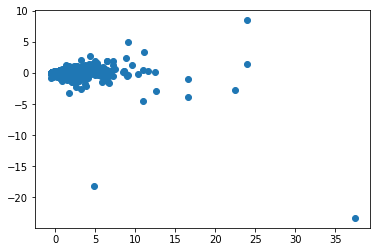

In [9]:
# make predictions on test set
y_pred_train = gsearch_dt.predict(x_train)
y_pred = gsearch_dt.predict(x_test)
print(y_pred)

# compute metrics 
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred)

train_mae = mean_absolute_error(y_train,y_pred_train)
test_mae = mean_absolute_error(y_test,y_pred)

train_r_squared = r2_score(y_train,y_pred_train)
test_r_squared = r2_score(y_test,y_pred)

train_adj_r_squared = 1 - (1-gsearch_dt.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
test_adj_r_squared = 1 - (1-gsearch_dt.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

train_mape = mean_absolute_percentage_error(y_train,y_pred_train)
test_mape = mean_absolute_percentage_error(y_test,y_pred)

print("training mse: {}, testing mse: {}".format(train_mse, test_mse))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(train_mse), np.sqrt(test_mse)))
print("training mae: {}, testing mae: {}".format(train_mae, test_mae))
print("training R2: {}, testing R2: {}".format(train_r_squared, test_r_squared))
# print("training R2: {}, testing R2: {}".format(dt.score(x_train, y_train), dt.score(x_test, y_test)))
print("training adjusted R2: {}, testing adjusted R2: {}".format(train_adj_r_squared, test_adj_r_squared))
print("training mape: {}, testing mape: {}".format(train_mape, test_mape))

# residual plot
x_axis = y_test.squeeze() # fitted value
y_axis = y_test.squeeze()- y_pred.squeeze() # residual
plt.scatter(x_axis,y_axis) 

In [10]:
# test 2: best parameter is 'min_samples_split': [7,12,15,20,25]

In [11]:
params = {'min_samples_split': [7,12,15,20,25]}
gsearch_dt = GridSearchCV(tree.DecisionTreeRegressor(random_state=42), 
                          params, 
                          scoring = 'neg_mean_squared_error',
                          verbose=1, 
                          cv=3, 
                          n_jobs=-1)
gsearch_dt.fit(x_train, y_train)
print('best score:', gsearch_dt.best_score_)
print('best parameters: ', gsearch_dt.best_params_)
print('best estimators: ', gsearch_dt.best_estimator_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.0s finished


best score: -0.12315555277827599
best parameters:  {'min_samples_split': 15}
best estimators:  DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=15, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')


[ 0.03902363 -0.40732231 -0.27630442 ... -0.42735228 -0.35060985
 -0.32874966]
training mse: 0.030235875068050224, testing mse: 0.098731964339167
training rmse: 0.17388466024365182, testing rmse: 0.3142164291362993
training mae: 0.03097720331422784, testing mae: 0.051264393354935614
training R2: 0.9697638715834644, testing R2: 0.8901358925457995
training adjusted R2: -0.0303567430927123, testing adjusted R2: -0.09989323925240501
training mape: 17.079758344677433, testing mape: 30.072551540034866


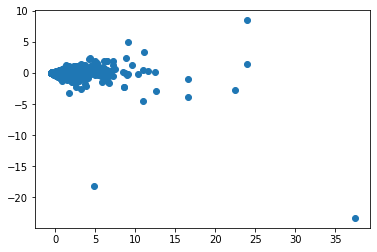

In [12]:
# make predictions on test set
y_pred_train = gsearch_dt.predict(x_train)
y_pred = gsearch_dt.predict(x_test)
print(y_pred)

# compute metrics 
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred)

train_mae = mean_absolute_error(y_train,y_pred_train)
test_mae = mean_absolute_error(y_test,y_pred)

train_r_squared = r2_score(y_train,y_pred_train)
test_r_squared = r2_score(y_test,y_pred)

train_adj_r_squared = 1 - (1-gsearch_dt.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
test_adj_r_squared = 1 - (1-gsearch_dt.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

train_mape = mean_absolute_percentage_error(y_train,y_pred_train)
test_mape = mean_absolute_percentage_error(y_test,y_pred)

print("training mse: {}, testing mse: {}".format(train_mse, test_mse))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(train_mse), np.sqrt(test_mse)))
print("training mae: {}, testing mae: {}".format(train_mae, test_mae))
print("training R2: {}, testing R2: {}".format(train_r_squared, test_r_squared))
# print("training R2: {}, testing R2: {}".format(dt.score(x_train, y_train), dt.score(x_test, y_test)))
print("training adjusted R2: {}, testing adjusted R2: {}".format(train_adj_r_squared, test_adj_r_squared))
print("training mape: {}, testing mape: {}".format(train_mape, test_mape))

# residual plot
x_axis = y_test.squeeze() # fitted value
y_axis = y_test.squeeze()- y_pred.squeeze() # residual
plt.scatter(x_axis,y_axis) 

### Random Forest

#### (a) Basic Random Forest with Default Parameters

/Users/tohjiaxuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/tohjiaxuan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


[ 0.02657904 -0.40823948 -0.29224453 ... -0.4215418  -0.37936335
 -0.32764996]
training mse: 0.013070323820194664, testing mse: 0.04614068945151891
training rmse: 0.1143255169251146, testing rmse: 0.21480383947108328
training mae: 0.018370899627338233, testing mae: 0.04342492169084671
training R2: 0.9869295666626594, testing R2: 0.9486568944734182
training adjusted R2: 0.9869280332298823, testing adjusted R2: 0.9486026287722726
training mape: 10.106902818500444, testing mape: 26.91128826384313


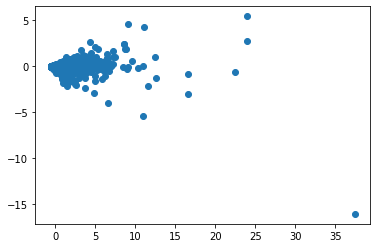

In [34]:
# train model
rforest = ensemble.RandomForestRegressor()
rforest.fit(x_train,y_train)

# make predictions on test set
y_pred_train = rforest.predict(x_train)
y_pred = rforest.predict(x_test)
print(y_pred)

# compute metrics 
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred)

train_mae = mean_absolute_error(y_train,y_pred_train)
test_mae = mean_absolute_error(y_test,y_pred)

train_r_squared = r2_score(y_train,y_pred_train)
test_r_squared = r2_score(y_test,y_pred)

train_adj_r_squared = 1 - (1-rforest.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
test_adj_r_squared = 1 - (1-rforest.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

train_mape = mean_absolute_percentage_error(y_train,y_pred_train)
test_mape = mean_absolute_percentage_error(y_test,y_pred)

print("training mse: {}, testing mse: {}".format(train_mse, test_mse))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(train_mse), np.sqrt(test_mse)))
print("training mae: {}, testing mae: {}".format(train_mae, test_mae))
print("training R2: {}, testing R2: {}".format(train_r_squared, test_r_squared))
# print("training R2: {}, testing R2: {}".format(dt.score(x_train, y_train), dt.score(x_test, y_test)))
print("training adjusted R2: {}, testing adjusted R2: {}".format(train_adj_r_squared, test_adj_r_squared))
print("training mape: {}, testing mape: {}".format(train_mape, test_mape))

# residual plot
x_axis = y_test.squeeze() # fitted value
y_axis = y_test.squeeze()- y_pred.squeeze() # residual
plt.scatter(x_axis,y_axis) 

In [35]:
rforest.get_params(deep=True)

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### (b) Random Forest using Best Estimators from Grid Search
- did 2 tests to kinda see which one better

In [14]:
# test 1: best parameter is 150

In [15]:
params = {'n_estimators': [10,50,100,150]}
grid_search_cv = GridSearchCV(ensemble.RandomForestRegressor(random_state=42), 
                              params, 
                              scoring = 'neg_mean_squared_error', 
                              verbose=1, 
                              cv=3,
                              n_jobs = -1)
grid_search_cv.fit(x_train, y_train)
print('best score:', grid_search_cv.best_score_)
print('best parameters: ', grid_search_cv.best_params_)
print('best estimators: ', grid_search_cv.best_estimator_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.7min finished
/Users/tohjiaxuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


best score: -0.09410105417199768
best parameters:  {'n_estimators': 150}
best estimators:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)


[ 0.0331047  -0.40677919 -0.29221728 ... -0.41793323 -0.37364581
 -0.32498965]
training mse: 0.010984088796300234, testing mse: 0.024537196035757096
training rmse: 0.10480500367969191, testing rmse: 0.15664353173928727
training mae: 0.016236141953189658, testing mae: 0.04030446956584716
training R2: 0.9890158191672612, testing R2: 0.9726962067458047
training adjusted R2: -0.011102698187348103, testing adjusted R2: -0.02562005280342272
training mape: 9.143875820499202, testing mape: 25.455399327000965


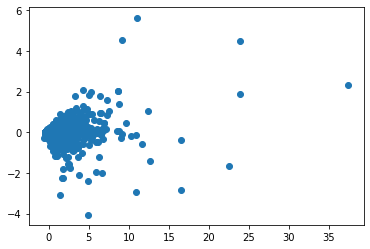

In [16]:
# make predictions on test set
y_pred_train = grid_search_cv.predict(x_train)
y_pred = grid_search_cv.predict(x_test)
print(y_pred)

# compute metrics 
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred)

train_mae = mean_absolute_error(y_train,y_pred_train)
test_mae = mean_absolute_error(y_test,y_pred)

train_r_squared = r2_score(y_train,y_pred_train)
test_r_squared = r2_score(y_test,y_pred)

train_adj_r_squared = 1 - (1-grid_search_cv.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
test_adj_r_squared = 1 - (1-grid_search_cv.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

train_mape = mean_absolute_percentage_error(y_train,y_pred_train)
test_mape = mean_absolute_percentage_error(y_test,y_pred)

print("training mse: {}, testing mse: {}".format(train_mse, test_mse))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(train_mse), np.sqrt(test_mse)))
print("training mae: {}, testing mae: {}".format(train_mae, test_mae))
print("training R2: {}, testing R2: {}".format(train_r_squared, test_r_squared))
# print("training R2: {}, testing R2: {}".format(dt.score(x_train, y_train), dt.score(x_test, y_test)))
print("training adjusted R2: {}, testing adjusted R2: {}".format(train_adj_r_squared, test_adj_r_squared))
print("training mape: {}, testing mape: {}".format(train_mape, test_mape))

# residual plot
x_axis = y_test.squeeze() # fitted value
y_axis = y_test.squeeze()- y_pred.squeeze() # residual
plt.scatter(x_axis,y_axis) 

In [17]:
# test 2: best parameter is 150

In [18]:
params = {'n_estimators': [100,150,200,250]}
grid_search_cv = GridSearchCV(ensemble.RandomForestRegressor(random_state=42), 
                              params, 
                              scoring = 'neg_mean_squared_error', 
                              verbose=1, 
                              cv=3,
                              n_jobs = -1)
grid_search_cv.fit(x_train, y_train)
print('best score:', grid_search_cv.best_score_)
print('best parameters: ', grid_search_cv.best_params_)
print('best estimators: ', grid_search_cv.best_estimator_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.0min finished
/Users/tohjiaxuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


best score: -0.09410105417199768
best parameters:  {'n_estimators': 150}
best estimators:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)


[ 0.0331047  -0.40677919 -0.29221728 ... -0.41793323 -0.37364581
 -0.32498965]
training mse: 0.010984088796300234, testing mse: 0.024537196035757096
training rmse: 0.10480500367969191, testing rmse: 0.15664353173928727
training mae: 0.016236141953189658, testing mae: 0.04030446956584716
training R2: 0.9890158191672612, testing R2: 0.9726962067458047
training adjusted R2: -0.011102698187348103, testing adjusted R2: -0.02562005280342272


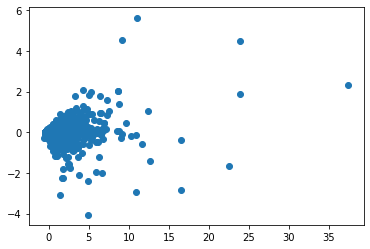

In [19]:
# make predictions on test set
y_pred_train = grid_search_cv.predict(x_train)
y_pred = grid_search_cv.predict(x_test)
print(y_pred)

# compute metrics 
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred)

train_mae = mean_absolute_error(y_train,y_pred_train)
test_mae = mean_absolute_error(y_test,y_pred)

train_r_squared = r2_score(y_train,y_pred_train)
test_r_squared = r2_score(y_test,y_pred)

train_adj_r_squared = 1 - (1-grid_search_cv.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
test_adj_r_squared = 1 - (1-grid_search_cv.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

train_mape = mean_absolute_percentage_error(y_train,y_pred_train)
test_mape = mean_absolute_percentage_error(y_test,y_pred)

print("training mse: {}, testing mse: {}".format(train_mse, test_mse))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(train_mse), np.sqrt(test_mse)))
print("training mae: {}, testing mae: {}".format(train_mae, test_mae))
print("training R2: {}, testing R2: {}".format(train_r_squared, test_r_squared))
# print("training R2: {}, testing R2: {}".format(dt.score(x_train, y_train), dt.score(x_test, y_test)))
print("training adjusted R2: {}, testing adjusted R2: {}".format(train_adj_r_squared, test_adj_r_squared))

# residual plot
x_axis = y_test.squeeze() # fitted value
y_axis = y_test.squeeze()- y_pred.squeeze() # residual
plt.scatter(x_axis,y_axis) 

In [40]:
params = {'n_estimators': [10]}
grid_search_cv = GridSearchCV(ensemble.RandomForestRegressor(random_state=42), 
                              params, 
                              scoring = 'neg_mean_squared_error', 
                              verbose=1, 
                              cv=3,
                              n_jobs = -1)
grid_search_cv.fit(x_train, y_train)
print('best score:', grid_search_cv.best_score_)
print('best parameters: ', grid_search_cv.best_params_)
print('best estimators: ', grid_search_cv.best_estimator_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.9s finished
/Users/tohjiaxuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


best score: -0.10634857881816642
best parameters:  {'n_estimators': 10}
best estimators:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)


[ 0.01776324 -0.40682939 -0.29398159 ... -0.41031373 -0.37562356
 -0.32639315]
training mse: 0.01173319558905452, testing mse: 0.027599273107747086
training rmse: 0.10831987624187225, testing rmse: 0.166130289555358
training mae: 0.017980922299665286, testing mae: 0.04217947691323271
training R2: 0.9882667060976893, testing R2: 0.9692888769441358
training adjusted R2: -0.011851892865857971, testing adjusted R2: -0.028685366254622258


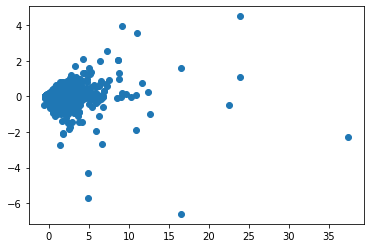

In [41]:
# make predictions on test set
y_pred_train = grid_search_cv.predict(x_train)
y_pred = grid_search_cv.predict(x_test)
print(y_pred)

# compute metrics 
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred)

train_mae = mean_absolute_error(y_train,y_pred_train)
test_mae = mean_absolute_error(y_test,y_pred)

train_r_squared = r2_score(y_train,y_pred_train)
test_r_squared = r2_score(y_test,y_pred)

train_adj_r_squared = 1 - (1-grid_search_cv.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
test_adj_r_squared = 1 - (1-grid_search_cv.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

train_mape = mean_absolute_percentage_error(y_train,y_pred_train)
test_mape = mean_absolute_percentage_error(y_test,y_pred)

print("training mse: {}, testing mse: {}".format(train_mse, test_mse))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(train_mse), np.sqrt(test_mse)))
print("training mae: {}, testing mae: {}".format(train_mae, test_mae))
print("training R2: {}, testing R2: {}".format(train_r_squared, test_r_squared))
# print("training R2: {}, testing R2: {}".format(dt.score(x_train, y_train), dt.score(x_test, y_test)))
print("training adjusted R2: {}, testing adjusted R2: {}".format(train_adj_r_squared, test_adj_r_squared))

# residual plot
x_axis = y_test.squeeze() # fitted value
y_axis = y_test.squeeze()- y_pred.squeeze() # residual
plt.scatter(x_axis,y_axis) 

In [42]:
rforest.get_params(deep=True)

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}